In [1]:
import numpy as np
import mylibrary.nnlib as tnn
import mylibrary.splinelib as tsp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import copy
matplotlib.rcParams['figure.figsize'] = (12, 8)

#### Dataset 0

In [2]:
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

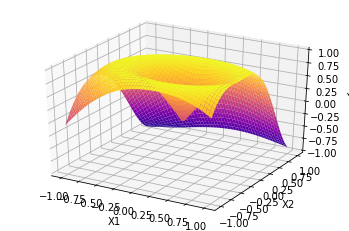

In [3]:
%matplotlib inline

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
# ax.scatter(X1, X2, Y)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

#### Dataset 1

In [4]:
# The two-dimensional domain of the fit.....
########https://scipython.com/blog/non-linear-least-squares-fitting-of-a-two-dimensional-data/#########
x1min, x1max, nx1 = -5, 4, 75
x2min, x2max, nx2 = -3, 7, 75
x1, x2 = np.linspace(x1min, x1max, nx1), np.linspace(x2min, x2max, nx2)
X1, X2 = np.meshgrid(x1, x2)

# Our function to fit is going to be a sum of two-dimensional Gaussians
def gaussian(x1, x2, x10, x20, x1alpha, x2alpha, A):
    return A * np.exp( -((x1-x10)/x1alpha)**2 -((x2-x20)/x2alpha)**2)

# A list of the Gaussian parameters: x10, x20, x1alpha, x2alpha, A
gprms = [(0, 2, 2.5, 5.4, 1.5),
         (-1, 4, 6, 2.5, 1.8),
         (-3, -0.5, 1, 2, 4),
         (3, 0.5, 2, 1, 5)
        ]

# Standard deviation of normally-distributed noise to add in generating
# our test function to fit.
# The function to be fit is Z.
Y = np.zeros(X1.shape)
for p in gprms:
    Y += gaussian(X1, X2, *p)
### Adding noise to the data
# noise_sigma = 0.1
# Z += noise_sigma * np.random.randn(*Z.shape)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

## reusing the variable name
x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

# Plot the 3D figure of the fitted function and the residuals.
%matplotlib tk

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
# ax.set_zlim(0,np.max(Y)+2)
plt.show()

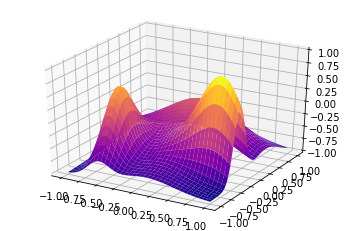

In [5]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
# ax.set_zlim(0,np.max(Z)+2)
plt.show()

In [6]:
# netList = []
xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)

### Using Pytorch Now

In [7]:
import torch
import torch.nn as nn

In [8]:
xx = torch.Tensor(xx)
yy = torch.Tensor(yy)

In [10]:
# RBF Layer

class RBF(nn.Module):
    """
    Transforms incoming data using a given radial basis function:
    u_{i} = rbf(||x - c_{i}|| / s_{i})
    Arguments:
        in_features: size of each input sample
        out_features: size of each output sample
    Shape:
        - Input: (N, in_features) where N is an arbitrary batch size
        - Output: (N, out_features) where N is an arbitrary batch size
    Attributes:
        centres: the learnable centres of shape (out_features, in_features).
            The values are initialised from a standard normal distribution.
            Normalising inputs to have mean 0 and standard deviation 1 is
            recommended.
        
        sigmas: the learnable scaling factors of shape (out_features).
            The values are initialised as ones.
        
        basis_func: the radial basis function used to transform the scaled
            distances.
    """

    def __init__(self, in_features, out_features, basis_func):
        super(RBF, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.centres = nn.Parameter(torch.Tensor(out_features, in_features))
        self.sigmas = nn.Parameter(torch.Tensor(out_features))
        self.basis_func = basis_func
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.centres, 0, 1)
        nn.init.constant_(self.sigmas, 1)

    def forward(self, input):
        size = (input.size(0), self.out_features, self.in_features)
        x = input.unsqueeze(1).expand(size)
        c = self.centres.unsqueeze(0).expand(size)
        distances = (x - c).pow(2).sum(-1).pow(0.5) * self.sigmas.unsqueeze(0)
        return self.basis_func(distances)



# RBFs

def gaussian(alpha):
    phi = torch.exp(-1*alpha.pow(2))
    return phi

def linear(alpha):
    phi = alpha
    return phi

def quadratic(alpha):
    phi = alpha.pow(2)
    return phi

def inverse_quadratic(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2))
    return phi

def multiquadric(alpha):
    phi = (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

def inverse_multiquadric(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

def spline(alpha):
    phi = (alpha.pow(2) * torch.log(alpha + torch.ones_like(alpha)))
    return phi

def poisson_one(alpha):
    phi = (alpha - torch.ones_like(alpha)) * torch.exp(-alpha)
    return phi

def poisson_two(alpha):
    phi = ((alpha - 2*torch.ones_like(alpha)) / 2*torch.ones_like(alpha)) \
    * alpha * torch.exp(-alpha)
    return phi

def matern32(alpha):
    phi = (torch.ones_like(alpha) + 3**0.5*alpha)*torch.exp(-3**0.5*alpha)
    return phi

def matern52(alpha):
    phi = (torch.ones_like(alpha) + 5**0.5*alpha + (5/3) \
    * alpha.pow(2))*torch.exp(-5**0.5*alpha)
    return phi

def basis_func_dict():
    """
    A helper function that returns a dictionary containing each RBF
    """
    
    bases = {'gaussian': gaussian,
             'linear': linear,
             'quadratic': quadratic,
             'inverse quadratic': inverse_quadratic,
             'multiquadric': multiquadric,
             'inverse multiquadric': inverse_multiquadric,
             'spline': spline,
             'poisson one': poisson_one,
             'poisson two': poisson_two,
             'matern32': matern32,
             'matern52': matern52}
    return bases

In [19]:
n_hidden = 5
model = nn.Sequential(RBF(2, n_hidden, gaussian),
                      nn.Linear(n_hidden, 1),
                     )
model[1].weight.data *= 2
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')

EPOCHS = 100000
for epoch in range(EPOCHS):

    yout = model(xx)
    loss = criterion(yout, yy)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%1000 == 0:
        print(epoch, 'Error = ', float(loss))
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if loss < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.24553100764751434


1000 Error =  0.06582280248403549




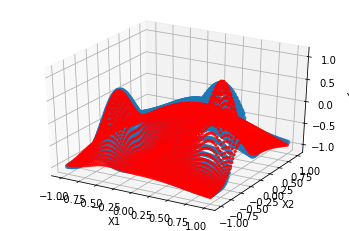

In [48]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()